In [1]:
import json
import pickle

class FilesLoader(): 
    """
    Extract recipes or supermarket's products from json files
    """
    
    def load_recipes(self, recipesFile):
        with open(recipesFile) as recipes_file:    
            recipes = json.load(recipes_file)
            nbImportedRecipes = len(recipes)
            # two empty recipes in .json file
            recipes = [recipe for recipe in recipes if recipe["nom"] ]
            # Some recipes have no ingredient
            recipes = [recipe for recipe in recipes if recipe["ingredients"] ]
            
            # When no separator between ingredients
            recipes = [recipe for recipe in recipes if len(recipe["ingredients"])>2 ]
            recipeCopy =[]
            for recipe in recipes :
                keep = True
                for ingredient in recipe["ingredients"] :
                    if len(ingredient) > 80 :
                        keep = False
                if keep :
                    recipeCopy.append(recipe)
            recipes = recipeCopy
            
            print str(nbImportedRecipes) + " imported recipes, " + str(len(recipes)) + " after parsing"
            
            return recipes
            
                            
    def load_supermarket(self, supermarketFile):
        with open(supermarketFile) as supermarket_file:    
            supermarket = json.load(supermarket_file)    
        print str(len(supermarket)) + " imported articles from supermarket"
        return supermarket
    
    
    def persist_object(self, obj, fileName):
        fileObject = open(fileName,'wb') 
        pickle.dump(obj, fileObject)   
        fileObject.close()
                
    def load_persisted_object(self, fileName):
        fileObject = open(fileName,'rb') 
        obj = pickle.load(fileObject)   
        fileObject.close()
        return obj
    

In [2]:
import re
import random
import numpy as np
from nltk.stem.porter import PorterStemmer
from datetime import datetime
from copy import deepcopy
import itertools


class FridgeManager:
    '''
   
    '''        
    
    def get_quant_supermarket(self, supermarket):
        """
        Extract quantities (numbers, separators, unities) from products list
        Then add fields "weight_kg", "volume_l" and "nb"
        """
        for article in supermarket :
    
        # Format type : la barquette de 8 - 200 g
            result1 =  re.findall("\d+ - \d+", article["quantite"])
            if len(result1) > 0:
                unity = re.split(result1[-1], article["quantite"])[-1].lstrip(" ").rstrip("\n")
                if unity :
                    article["weight_kg"], article["volume_l"], article["nb"] = \
                                    self.conversion_quantity(result1[-1].split('-')[1], unity)
            else:
                # Format type : la boîte de 4 x 25g    /   le paquet de 6 x 20,83g
                result2 = re.findall("\d+ \w{1} \d+,?\d*", article["quantite"])
                if len(result2)> 0:
                    unity = re.split(result2[-1], article["quantite"])[-1].lstrip(" ").rstrip("\n")
                    if unity :
                        nbs = re.split("x",result2[-1])
                        nb = str(int(nbs[0])*float(re.sub(",",".",nbs[1])))
                        article["weight_kg"], article["volume_l"], article["nb"] = self.conversion_quantity(nb, unity)
                else :
                    # Format type : les 10 poches de 200ml
                    result3 = re.search(r'\d+ \w* \w* \d+ \w*', article["quantite"])
                    if result3 :
                        nbs = result3.group(0).split(" ")
                        nb = str(int(nbs[0])*float(re.sub(",",".",nbs[-2])))
                        article["weight_kg"], article["volume_l"], article["nb"] = self.conversion_quantity(nb, nbs[-1]) 
                        
                    else :
        
        #               # Other numerics 
                        result4 = re.findall(r'\d+', article["quantite"])
                        if result4 :
                            unity = re.split(result4[-1], article["quantite"])[-1].lstrip(" ").rstrip("\n")
                            article["weight_kg"], article["volume_l"], article["nb"] = \
                                                self.conversion_quantity(result4[-1], unity)
                            
                        # Others :  le poulet, la pièce, la botte, la gousse de vanille ...
                        else :
                            article["weight_kg"], article["volume_l"], article["nb"] = 0.0, 0.0, 1
                            
    
                      
    def get_quant_recipes(self, recipes):
        """
        Extract quantities (numbers, separators, unities) from recipes
        Then add fields "weight_kg", "volume_l" and "nb"
        """
        errRecipes = [False]*len(recipes)
        for j, recipe in enumerate(recipes) :
            for i in range(len(recipe["ingredients"])):
                err = False
                ingredient = dict()
                ingredient["nom"] = recipe["ingredients"][i]
                # test on floats then on integers
                result = re.findall(r"\d+/\d+|\d*\,\d+|\d+", recipe["ingredients"][i])
                # unity or items number
                if result :
                    unity = re.split(result[-1], recipe["ingredients"][i])[-1].lstrip(" ").rstrip("\n")
                    ingredient["weight_kg"], ingredient["volume_l"], ingredient["nb"] = \
                                                                    self.conversion_quantity(result[-1], unity)
                    if ingredient["weight_kg"] > 0 :
                        ingredient["nb"] = 1
                else :
                    ingredient["nb"] = 1
                    ingredient["weight_kg"], ingredient["volume_l"] = 0.0, 0.0
                del recipe["ingredients"][i]
                recipe["ingredients"].insert(0,ingredient)
                
                if err :
                    errRecipes[j] = True
        noErr = [not i for i in errRecipes]
        recipes = list(itertools.compress(recipes, noErr))

          
                
    def link_recipes_supermarket(self, recipes, supermarket):
        """
        Constructs a list of common words between recipes and supermarket
        Then add identifiers in supermarket, and common words in recipes and supermarket 
        """

        stemmer = PorterStemmer()
        
        # Words in Supermarket 
        wordsSupermarket = [article["marque"].lower().replace("'"," ").replace("+"," ")\
                .replace("oeuf","\u0153uf").split() for article in supermarket]
        wordsSupermarket = [word for sublist in wordsSupermarket for word in sublist ]
        wordsSupermarket = [stemmer.stem(word) for word in wordsSupermarket]
        wordsSupermarket = list(set(wordsSupermarket))
        
        # Words in Recipes
        recipesWords = []
        for recipe in recipes :
            for ingredient in recipe["ingredients"]:
                recipesWords.extend(ingredient["nom"].lower().replace("'"," ").replace("+"," ")\
                        .replace(","," ").replace("-"," ").replace("oeuf","\u0153uf").replace("oeufs","\u0153ufs").split())    
        
        recipesWords = [word for word in recipesWords if not bool(re.match(r'[0-9]', word)) ]
        recipesWords = [stemmer.stem(word) for word in recipesWords]
        recipesWords = [word for word in recipesWords if len(word)>2]
        recipesWords = list(set(recipesWords))
        
        # Common Words
        commonWords = [word for word in recipesWords if word in wordsSupermarket]
        
        # remove ambiguous terms
        ambiguousWords = ["soup"] 
        commonWords = [word for word in commonWords if word not in ambiguousWords]
        
        # Add common words in recipes
        for recipe in recipes :
            for ingredient in recipe["ingredients"]:
                identifiers = [stemmer.stem(word) for word in ingredient["nom"].lower().replace("'"," ").replace("+"," ")\
                        .replace(","," ").replace("-"," ").replace("oeuf","\u0153uf").replace("oeufs","\u0153ufs").split()]
                identifiers = [word for word in identifiers if word in commonWords]
                ingredient["identifiers"] = identifiers
                
        # remove ingredients if exist in inexhaustiveSuff
        inexhaustiveStuff = self.list_inexhaustible_stuff()
        for recipe in recipes :
            errIng = [False]*len(recipe["ingredients"])
            for i, ingredient in enumerate(recipe["ingredients"]):
                for identifier in ingredient["identifiers"]:
                    if identifier in inexhaustiveStuff :
                        errIng[i] = True
    
            noErr = [not i for i in errIng]
            recipe["ingredients"] = list(itertools.compress(recipe["ingredients"], noErr))
        recipes = [recipe for recipe in recipes if len(recipe["ingredients"])>0]  
            
        # Add common words and identifiers in supermarket    
        for article in supermarket :
            identifiers = [stemmer.stem(word) for word in article["marque"].lower().replace("'"," ").replace("+"," ")\
                    .replace(","," ").replace("-"," ").replace("oeuf","\u0153uf").replace("oeufs","\u0153ufs").split()]
        
            # In supermarket format, first words are meanfull 
            if identifiers[0].lower() not in ["p'tit","petit", "petits","les", "la", "le"]:
                article["foodType"] = identifiers[0]
            else :
                article["foodType"] = identifiers[1]
                
            identifiers = [word for word in identifiers if word in commonWords]
            article["identifiers"] = identifiers
            
        # Clean supermarket products list    
        allSupermarket = len(supermarket)   
        supermarket = [article for article in supermarket if article["foodType"] in commonWords] 
        print str(len(supermarket))+ " usefull products on " + str(allSupermarket) + " proposed products in Supermarket"
        
        # Filter workable recipes 
        allrecipes = len(recipes)
        recipes = [recipe for recipe in recipes if self.workable_recipe(recipe, supermarket, isSupermarket=True)]
        print str(len(recipes))+ " workable recipes on " + str(allrecipes) + " proposed"
            
        return recipes, supermarket
    
    
 
    def display_recipes(self, recipes, example=False):
        for recipe in recipes :
            self.display_recipe(recipe, example)
            
                      
    def display_recipe(self, recipe, example=False):
        print "recipe : " + recipe["nom"] + "\n"
        print "Ingredients list :"
        
        if example :
            for ingredient in recipe["ingredients"] :
                print ingredient
        else :
            for ingredient in recipe["ingredients"] :
                if ingredient["nom"] :
                    print ingredient["nom"]
                else :
                    print ingredient
                if ingredient["nb"] :
                    print "nb : "+ str(ingredient["nb"])
                if ingredient["weight_kg"] :
                    print "weight : "+ str(ingredient["weight_kg"])
                if ingredient["volume_l"] :
                    print "volume : "+ str(ingredient["volume_l"])
                      
                        
    def display_supermarket(self, supermarket):
        print "Available foods in Carrefour Drive: \n "
        for product in supermarket:
            print product["marque"] + ", " +  product["quantite"]  
            
            
    def display_fridge(self, fridge):
        print "\n Fridge contents \n "
        for product in fridge:
            print product["marque"] + ", " + product["quantite"][1:-1] + ", nb: "+ str(product["nb"]) \
             + ", wt: "+ str(product["weight_kg"]) + ", V: " + str(product["volume_l"])
                
      
    def conversion_quantity(self, nb, unity) :
        '''
        convert extracted quantity in all usefull unities
        return a tuple : weight(kg), volume(L), nb
        '''
        eps = 1e-6
        
        unity = unity.lower()
        unity = unity.encode('ascii', 'replace')
        m = re.match(r"(\d+)/(\d+)", nb)
        
        if bool(m):
            if float(m.group(2))>0 :
                nb = float(m.group(1))/float(m.group(2))
            else : nb = float(m.group(1))
        else :
            nb = float(re.sub(',', '.', nb))
        
    
        weight_kg = 0
        volume_l = 0
        if unity.startswith("kg") :
            weight_kg = nb * 1.0 
            volume_l = nb * 1.25
            nb = 1
        elif unity.startswith("g") and not unity.startswith("go"):
            weight_kg = nb/1000.0 
            volume_l = nb/1000.0       
            nb = 1
        elif unity.startswith("l"):
            weight_kg = nb / 1.25 
            volume_l = nb * 1.0  
            nb = 1
        elif unity.startswith("cl"):
            weight_kg = nb / 125.0 
            volume_l = nb / 100.0
            nb = 1
        elif unity.startswith("ml"):
            weight_kg = nb / 1250.0 
            volume_l = nb / 1000.0
            nb = 1
        elif unity.startswith("cuillere a soupe") or unity.startswith("c a soupe")\
            or unity.startswith("c a s") or unity.startswith("c. a s") or unity.startswith("c de soupe"):
            weight_kg = nb * 1.2 / 100 
            volume_l = nb * 1.5 /100
            nb = 1
        elif unity.startswith("cuillere a cafe") or unity.startswith("c a cafe")\
            or unity.startswith("c a c") or unity.startswith("c. a c"):    
            weight_kg = nb * 0.4 / 100 
            volume_l = nb * 0.5 /100
            nb = 1
            
        return  weight_kg, volume_l, nb    
    
    
    
    def list_inexhaustible_stuff(self):
        """
        Some no consumable stuff 
        """
        stemmer = PorterStemmer()
        
        inexhaustibleStuff = [u"poivre", u"sel", u"poche a douille", u"papier aluminium", u"eau", u"mixer",
                             u"pipette en plastique", u"couscoussier", u"bassine", u"bol", u"planche", u"découper",
                             u"couteau", u"sauteuse", u"verre mesureur", u"casserole"]
        inexhaustibleStuff = [truc.lower().split() for truc in inexhaustibleStuff]
        inexhaustibleStuff = [word for sublist in inexhaustibleStuff for word in sublist ]
        inexhaustibleStuff = [stemmer.stem(word) for word in inexhaustibleStuff]
        inexhaustibleStuff = list(set(inexhaustibleStuff)) 
        
        return inexhaustibleStuff
    
    
    
    def workable_recipe(self, recipe, products, isSupermarket=False):
        """
        Check if all ingredients in the recipe are available in products list
        If products list is a fridge, add some tests (best match, support oldest products, check quantities)  
        """
        eps = 1e-6
        
        availableIngredients = np.zeros(len(recipe["ingredients"]))
        usedProducts = np.zeros(len(recipe["ingredients"]))
        
        if isSupermarket :
        
            for i in range(len(recipe["ingredients"])) :  
                for product in products :                    
                    if product["foodType"] in recipe["ingredients"][i]["identifiers"] :   
                        availableIngredients[i] = 1
                        break
                        
            return (sum(availableIngredients) == len(recipe["ingredients"])) 
            
            
        else :
            # Fridge
            for i in range(len(recipe["ingredients"])) : 
                productsToCompare = []    
                for product in products :
                    if product["foodType"] in recipe["ingredients"][i]["identifiers"] :
                        if self.sufficient_quantity(product, recipe["ingredients"][i]) :
                            productsToCompare.append(product)
           
                if len(productsToCompare) :
                    if len(productsToCompare)> 1 :
                        usedProduct = self.find_best_product(recipe["ingredients"][i], productsToCompare)
                        if usedProduct : 
                            availableIngredients[i] = 1 
                            usedProducts[i] = products.index(usedProduct)
                    else :
                        availableIngredients[i] = 1
                        usedProducts[i] = products.index(productsToCompare[0])

            if sum(availableIngredients) == len(recipe["ingredients"]) :
                return True, usedProducts
            else : 
                return False, availableIngredients
            
            
            
    
    def find_best_product(self, ingredient, productsToCompare, testDate=False) :
        """
            1. Food Type  
            2. Other concordant words
            3. Oldest first 
        """

        productsScore = []
        for product in productsToCompare :
            score = 0 
            
            for identifiant in product["identifiers"]:
                if identifiant in ingredient["identifiers"] :
                    score += 10           
                
            productsScore.append(score)
                
        scoreMax = max(productsScore)
        
        if scoreMax == 0 :
            print "no matching product"
            return
        
        if not testDate :
            for i, product in enumerate(productsToCompare) :
                if productsScore[i] == scoreMax :
                    return product 
        else :
            oldestDate = datetime.now()
        
            for i, product in enumerate(productsToCompare) :
                if productsScore[i] == scoreMax :
                    if product["purchase_date"] < oldestDate :
                        oldestDate = product["purchase_date"]
                        
            for i, product in enumerate(productsToCompare) :
    
                if productsScore[i] == scoreMax  and  product["purchase_date"] == oldestDate :
                    return product  
         

    def sufficient_quantity(self, product, ingredient):
        ''' 
        check if quantity of product in the fridge is sufficient for the recipe
        '''
        # avoid float comparison to zero 
        eps = 1e-6
                
        if product['weight_kg'] > eps  and ingredient['weight_kg'] > eps :
            if product['weight_kg'] >= ingredient['weight_kg'] :
                return True
            else :
                return False
        else :
            if product["nb"] > eps and product["nb"] >= ingredient['nb']:
                return True
            else :
                return False
            
    
    def create_fridge(self, supermarket, nbElements):                 
    
        fridge = deepcopy(random.sample(supermarket,  nbElements))

        for ingredient in fridge :
            ingredient["purchase_date"] = datetime.now()
        return fridge
    
    
    def buy_product(self, ingredient, supermarket, fridge):
        """
        Find product in supermarket that match better with ingredient, then buy it :
        - if product not already in fridge, add it
        - else add quantities to existing ones  
        """
        eps = 1e-6

        productsToCompare = [product for product in supermarket if product["foodType"] in ingredient["identifiers"]]

        if len(productsToCompare)> 0 :
            usedProduct = self.find_best_product(ingredient, productsToCompare)
            
            existingFood = [food for food in fridge if usedProduct["marque"] == food["marque"] \
                                                        and usedProduct["quantite"] == food["quantite"] ]
            if existingFood :
                existingFood = existingFood[0]
                existingFood["nb"] += usedProduct["nb"]
                existingFood["weight_kg"] += usedProduct["weight_kg"]
                existingFood["volume_l"] += usedProduct["volume_l"]
                purchasedProduct = existingFood
            else :
                purchasedProduct = deepcopy(usedProduct)
                purchasedProduct["purchase_date"] = datetime.now()
                fridge.append(purchasedProduct)
                print "purchases product :" + purchasedProduct["marque"]
                
            # recursive fonction 
            if not self.sufficient_quantity(purchasedProduct, ingredient):
                self.buy_product(ingredient, supermarket, fridge)
            
        else : 
            print "No article available in supermarket for this ingredient"
     
                        
                        
    def cook(self, recipe, fridge):
        '''
        Function only called after checking that recipe is workable
        so all ingredients are available with sufficient quantities
        
        Substract quantities used for each ingredient of the recipe 
        '''
        eps = 1e-6
        isWorkable, products = self.workable_recipe(recipe, fridge)
        if not isWorkable :
            print "Recipe not workable, lake of some ingredients"
            return
        else :
            for i in range(len(products)) :
                # If proportions weight/volume for both recipe and fridge
                if fridge[int(products[i])]["weight_kg"] > eps and recipe["ingredients"][i]["weight_kg"] > eps:
                    fridge[int(products[i])]["weight_kg"] -= recipe["ingredients"][i]["weight_kg"]
                    fridge[int(products[i])]["volume_l"] -= recipe["ingredients"][i]["volume_l"]
                else :
                    if fridge[int(products[i])]["nb"]> eps and  fridge[int(products[i])]["nb"] >= recipe["ingredients"][i]["nb"] :
                        fridge[int(products[i])]["nb"] -= recipe["ingredients"][i]["nb"]
                    else :
                        print "error in FridgeManager.cook function "
       
    
    def clean_fridge(self, fridge, threshold = 0.05) :
        """
        remove ingredient from fridge if The remainder is very low 
        (threshold = 0.05 => 50 g)
        """
        eps = 1e-2
        toClean = [False]*len(fridge)
        for i, ingredient in enumerate(fridge) :
            if ingredient["nb"]<eps :
                toClean[i] = True
            else :
                if eps < abs(ingredient["weight_kg"]) and ingredient["weight_kg"] < threshold :
                    toClean[i] = True
                    
        toKeep = [not i for i in toClean]
        fridge = list(itertools.compress(fridge, toKeep))
        
        return fridge
    
                
    def propose_recipe(self, products, recipes, prohibitedRecipes, supermarket) :
        '''
        Choose in an authorized recipes list one recipe minimizing shopping 
        In this version, if recipe matches, it is purchased, without user's validation
        '''
        
        recipes = [recipe for recipe in recipes if recipe not in prohibitedRecipes]
        random.shuffle(recipes)
        
        for recipe in recipes :
            isWorkable, statusPerIngredient =  self.workable_recipe(recipe, products)
            if isWorkable :
                print "Nothing to buy, go cooking"
                return recipe
            
        # If no workable recipe, go shopping
        # Find recipe with minimum ingredients to buy
        missing = 1
        while missing < 5 :
            for recipe in recipes :
                isWorkable, statusPerIngredient =  self.workable_recipe(recipe, products)
                if sum(statusPerIngredient) == len(recipe["ingredients"]) - missing:

                    for i, ingredient in enumerate(recipe["ingredients"]):
                        if statusPerIngredient[i] == 0 :
                            print "automatic purchase for ingredient :" + ingredient["nom"]
                            sup_copy = deepcopy(supermarket)
                            self.buy_product(ingredient, sup_copy, products)
                    return recipe
            missing += 1      
            
            
    def propose_recipe_2(self, products, recipes, prohibitedRecipes, supermarket, nbSelectableRecipes = 5) :
        '''
        Second version. A list of recipes are send to user for decision
        '''

        selectableRecipes = []  
        
        recipes = [recipe for recipe in recipes if recipe not in prohibitedRecipes]
        random.shuffle(recipes)
        
        for recipe in recipes :
            isWorkable, statusPerIngredient =  self.workable_recipe(recipe, products)
            if isWorkable and len(selectableRecipes) < nbSelectableRecipes:
                selectableRecipes.append(recipe) 
                
            # If no workable recipe, go shopping
            # Find recipe with minimum ingredients to buy
        missing = 1
        while missing < 5  and len(selectableRecipes)<nbSelectableRecipes :
            for recipe in recipes :
                isWorkable, statusPerIngredient =  self.workable_recipe(recipe, products)
                if (sum(statusPerIngredient) == len(recipe["ingredients"]) - missing) and \
                                                                        len(selectableRecipes) < nbSelectableRecipes:
                    selectableRecipes.append(recipe)
            missing += 1 
            
        # Interact with user
        gi = GraphicalInterface()
        gi.display_choices(selectableRecipes)
        recipe = selectableRecipes[gi.sendUserChoice()]
        
        isWorkable, statusPerIngredient =  self.workable_recipe(recipe, products)
        if isWorkable :
            print "Nothing to buy, go cooking"
            return recipe
        else :
            for i, ingredient in enumerate(recipe["ingredients"]):
                if statusPerIngredient[i] == 0 :
                    print "Automatic purchase for ingredient :" + ingredient["nom"]
                    spk_copy = deepcopy(supermarket)
                    self.buy_product(ingredient, spk_copy, products)
            return recipe


In [3]:
from Tkinter import *

class GraphicalInterface():
    
    def __init__(self):
        self.root = Tk()
        self.var = IntVar()
    
    def sendUserChoice(self):
        return self.var.get()
   
    def display_choices(self, recipes):   
       
        for i in range(len(recipes)):      
            Ri = Radiobutton(self.root, text=recipes[i]["nom"], variable=self.var, value=i, tristatevalue=0)\
                                                                                                .grid(row=i, sticky=W)
        Button(self.root, text = "OK", command = self.root.quit).grid(row=len(recipes), sticky=W)
        
        self.root.mainloop()
        self.sendUserChoice()
        self.quit()
        
    def quit(self):
        self.root.destroy()

In [27]:
    # =================#    
    # Data Preparation #
    # =================#    
                      
                       
fl = FilesLoader()
recipes = fl.load_recipes('C:/Users/thaunayf/Documents/Formation_Python/DataChallenge6/recettes.json')
supermarket = fl.load_supermarket('C:/Users/thaunayf/Documents/Formation_Python/DataChallenge6/supermarche.json') 

fm = FridgeManager()

fm.display_recipes(recipes[:3], example=True)  
fm.display_supermarket(supermarket[:3])  

# add fields nb, weight and volume to each product in supermarket     
fm.get_quant_supermarket(supermarket)
# add fields nb, weight and volume to each ingredient in recipes   
fm.get_quant_recipes(recipes)

# add field "identifiersWords" from common words 
# then clean recipes and supermarket 
recipes, supermarket = fm.link_recipes_supermarket(recipes, supermarket)
      
# pickle recipes et supermarket 

fl.persist_object(recipes, "recipesFile")
fl.persist_object(supermarket, "supermarketFile")

17071 imported recipes, 14844 after parsing
8869 imported articles from supermarket
recipe : Joues de porc à l'orange

Ingredients list :

            Curry
        

            Coriandre (poudre, grain)
        

            1/2 l de sauce tomate 
        

            70g  de farine
        

            1 bouteille de vin rosé sec
        

            Poivre grain, sel/poivre
        

            Bouquet garni
        

            2-3 oranges juteuses non traitées
        

            2-3 carottes
        

            2 oignons
        

            1 gousse d'ail
        

            1,5 kg de joues de porc
        
recipe : Lasagne bolognaise

Ingredients list :

            50cl de lait
        

            Pour la sauce Béchamel :
        

            50g de beurre
        

            2 cuillères à soupe de farine
        

            Sel, poivre, noix de muscade
        

            Persil hâché
        

            250g de sauce tomate
        

            Pour 

In [4]:
    fl = FilesLoader()
    fm = FridgeManager()
    
    # Unpickle recipes and supermarket
    recipes = fl.load_persisted_object("recipesFile")
    supermarket = fl.load_persisted_object("supermarketFile")
          
    print len(recipes) 
    print len(supermarket) 
           
    # create a fridge
    fridge = fm.create_fridge(supermarket, 50)  
    fm.display_fridge(fridge)
         

7048
7814

 Fridge contents 
 
Fromage  Vieux Pané, la part de 200 g, nb: 1, wt: 0.2, V: 0.2
Vin rosé Ile de Beauté Réserve de Padulone, la bouteille de 75cl, nb: 1, wt: 0.6, V: 0.75
Comté AOP 12 mois Juraflore, le sachet de 400 g, nb: 1, wt: 0.4, V: 0.4
Saucisse sèche pur porc Justin Bridou, le paquet de 275 g, nb: 1, wt: 0.275, V: 0.275
Fromage de chèvre mini bûches Soignon, les 6 mini bûches de 25 g, nb: 1, wt: 0.025, V: 0.025
Pains aux raisins  , la boite de 4 - 380 g, nb: 1, wt: 0.38, V: 0.38
Biscuits tablette chocolat lait Carrefour, la boite de 9 - 140 g, nb: 1, wt: 0.14, V: 0.14
Saucisses halal knacks de volaille Mahdia, le paquet de 10 - 300 g, nb: 1, wt: 0.3, V: 0.3
Pâté de porc Hénaff, la boite de 154 g, nb: 1, wt: 0.154, V: 0.154
Biscuits sablés chocolat noir Michel et Augustin, le paquet de 178 g, nb: 1, wt: 0.178, V: 0.178
Cordon Bleu dinde Le Gaulois, la boite de 4 - 400 g, nb: 1, wt: 0.4, V: 0.4
Boisson avoine calcium Bjorg, la brique de 1 L, nb: 1, wt: 0.8, V: 1.0
Noix

In [34]:
    # ====================================#
    #     Simulate one year fridge's      #
    # ====================================#
                
    # @param to decide if recipes are validated by user or not (usefull in order to make fridge statistics)      
    userValidation = False       
             
    nbMealPerWeak = 14 # A renseigner par l'utilisateur
    nbWeaks = 52    
    lenfridgeAYear = []
           
    alreadyProposedRecipes = []
    for i in range(nbWeaks) :
        nbProposedRecipes = 0
        while nbProposedRecipes < nbMealPerWeak :
            
            if not userValidation :
                recipe = fm.propose_recipe(fridge, recipes, alreadyProposedRecipes, supermarket)
            else : 
                recipe = fm.propose_recipe_2(fridge, recipes, alreadyProposedRecipes, supermarket)
                 
            print recipe["nom"]
            
            fm.cook(recipe, fridge)
            fridge = fm.clean_fridge(fridge, threshold=0.1) 
            
            nbProposedRecipes += 1
            alreadyProposedRecipes.append(recipe)
                       
            lenfridgeAYear.append(len(fridge))
            i += 1 
                 
             
    print lenfridgeAYear
    fm.display_fridge(fridge)

Nothing to buy, go cooking
Pâte à pâtes fraîches
Nothing to buy, go cooking
Omelette légère
error in FridgeManager.cook function 
Nothing to buy, go cooking
Pâtes fraîches maison
Nothing to buy, go cooking
Pâte à nouilles
Nothing to buy, go cooking
Pâtes fraîches maison à la farine de châtaigne
automatic purchase for ingredient :
            Courgettes
        
purchases product :Courgettes  Petit Prix
Buns (recette maison)
automatic purchase for ingredient :
            800 g de viande de bœuf en tranche
        
purchases product :Viande de bœuf séchée Indiana Jerky
Brasérade
automatic purchase for ingredient :
            150g d'emmental râpé
        
purchases product :Emmental râpé Entremont
Gâteau aux cerises express
automatic purchase for ingredient :
            1 oignon moyen
        
purchases product :Oignons jaunes bio Carrefour Bio
Kéfta grillée
automatic purchase for ingredient :
            1 brick de crème liquide (20cl)
        
purchases product :Crème liquide semi-ép

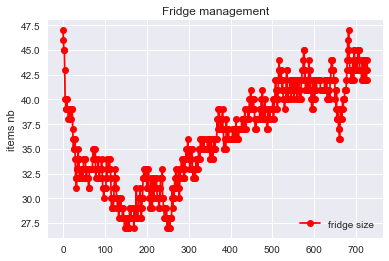

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.plot(lenfridgeAYear, 'o-', color="r", label="fridge size")
plt.ylabel("items nb")
plt.title("Fridge management")
plt.legend(loc="best")
plt.show()

In [6]:
userValidation = True       
             
nbMealPerWeak = 2 # A renseigner par l'utilisateur
nbWeaks = 2    
lenfridgeAYear = []

alreadyProposedRecipes = []
for i in range(nbWeaks) :
    nbProposedRecipes = 0
    while nbProposedRecipes < nbMealPerWeak :

        if not userValidation :
            recipe = fm.propose_recipe(fridge, recipes, alreadyProposedRecipes, supermarket)
        else : 
            recipe = fm.propose_recipe_2(fridge, recipes, alreadyProposedRecipes, supermarket)

        print recipe["nom"]

        fm.cook(recipe, fridge)
        fridge = fm.clean_fridge(fridge, threshold=0.1) 

        nbProposedRecipes += 1
        alreadyProposedRecipes.append(recipe)

        lenfridgeAYear.append(len(fridge))
        i += 1 


print lenfridgeAYear
fm.display_fridge(fridge)

Automatic purchase for ingredient :
            3 c à s (45 ml) beurre 
        
purchases product :Beurre demi-sel Carrefour
Steak de cheval au poivre
Nothing to buy, go cooking
Lasagnes au saumon
Automatic purchase for ingredient :
            500g de semoule
        
purchases product :Semoule extra fine Le Renard
Semoule au micro-ondes
Automatic purchase for ingredient :
            1,2 kg de pomme de terre à purée
        
purchases product :Purée pommes de terre en flocons Vico
Purée de pommes de terre maison
[38, 37, 38, 37]

 Fridge contents 
 
Fromage  Vieux Pané, la part de 200 g, nb: 1, wt: 0.1, V: 0.1
Vin rosé Ile de Beauté Réserve de Padulone, la bouteille de 75cl, nb: 1, wt: 0.6, V: 0.75
Biscuits tablette chocolat lait Carrefour, la boite de 9 - 140 g, nb: 1, wt: 0.14, V: 0.14
Saucisses halal knacks de volaille Mahdia, le paquet de 10 - 300 g, nb: 1, wt: 0.3, V: 0.3
Pâté de porc Hénaff, la boite de 154 g, nb: 1, wt: 0.154, V: 0.154
Biscuits sablés chocolat noir Michel et 